In [1]:
%%capture
!pip install einops
!pip install pytorch-lightning
!pip install bottleneck
!pip install torchtext

In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'

Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import gc
import torch
import einops
import pandas as pd
import numpy as np
import xarray as xr
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mpl
import ipywidgets as widgets
import optiver

from torch import nn
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader

In [4]:
def prepare_data(stock_id, stock_ind, set, time_ids, coarsen, norm, out):
    df_book = pd.read_parquet(f'{data_dir}/book_{set}.parquet/stock_id={stock_id}')
    df_min_second = df_book.groupby('time_id').agg(min_second=('seconds_in_bucket', 'min'))
    df_book = df_book.merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df_trade = pd.read_parquet(f'{data_dir}/trade_{set}.parquet/stock_id={stock_id}') \
        .merge(df_min_second, left_on='time_id', right_index=True) \
        .eval('seconds_in_bucket = seconds_in_bucket - min_second') \
        .drop('min_second', axis=1)
    df = pd.merge(df_book, df_trade, on=['time_id', 'seconds_in_bucket'], how='outer')
    df['stock_id'] = stock_id
    df = df.set_index(['stock_id', 'time_id', 'seconds_in_bucket'])
    df = df.to_xarray().astype('float32')
    df = df.reindex({'time_id': time_ids, 'seconds_in_bucket': np.arange(n_seconds)})
    for name in ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2',
         'bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']:
        df[name] = df[name].ffill('seconds_in_bucket')
    df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
    df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
    df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
    df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')
    df['current_vol'] = (df.log_return1 ** 2).sum('seconds_in_bucket') ** 0.5
    df['current_vol_2nd_half'] = (df.log_return1[..., 300:] ** 2).sum('seconds_in_bucket') ** 0.5
    if coarsen > 1:
        mean_features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price']
        sum_features = ['size', 'order_count']

        df = xr.merge((df[mean_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').mean(),
                       df[sum_features].coarsen({'seconds_in_bucket': coarsen}, coord_func='min').sum(),
                       df[['current_vol', 'current_vol_2nd_half']]))
        df['wap1'] = (df.bid_price1 * df.ask_size1 + df.ask_price1 * df.bid_size1) / (df.bid_size1 + df.ask_size1)
        df['wap2'] = (df.bid_price2 * df.ask_size2 + df.ask_price2 * df.bid_size2) / (df.bid_size2 + df.ask_size2)
        df['log_return1'] = np.log(df.wap1).diff('seconds_in_bucket')
        df['log_return2'] = np.log(df.wap2).diff('seconds_in_bucket')

    df['spread1'] = df.ask_price1 - df.bid_price1
    df['spread2'] = df.ask_price2 - df.ask_price1
    df['spread3'] = df.bid_price1 - df.bid_price2
    df['total_volume'] = df.ask_size1 + df.ask_size2 + df.bid_size1 + df.bid_size2
    df['volume_imbalance1'] = df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2
    df['volume_imbalance2'] = (df.ask_size1 + df.ask_size2 - df.bid_size1 - df.bid_size2) / df.total_volume
    for name in ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2', 'size', 'order_count', 'total_volume']:
        df[name] = np.log1p(df[name])
    df['volume_imbalance1'] = np.sign(df['volume_imbalance1']) * np.log1p(abs(df['volume_imbalance1']))

    for field in ['ask_price1','ask_price2','bid_price1', 'bid_price2', 'ask_size1','ask_size2', 'bid_size1','bid_size2','wap1', 'wap2',\
               'log_return1', 'log_return2', 'spread1', 'spread2', 'spread3', 'total_volume',
               'volume_imbalance1', 'volume_imbalance2']:
        df[field] = df[field].ffill(dim='seconds_in_bucket')

    df = df.fillna({'price': 1, 'size': 0, 'order_count': 0,'current_vol': 0, 'current_vol_2nd_half': 0})

    # fill the missing NAs
    df = df.fillna({'ask_price1': 1, 'ask_price2': 1, 'bid_price1': 1, 'bid_price2': 1,  'ask_size1': 0, 'ask_size2': 0,
               'bid_size1': 0, 'bid_size2': 0, 'price': 1, 'size': 0, 'order_count': 0, 'wap1': 1, 'wap2': 1,
               'log_return1': 0, 'log_return2': 0, 'spread1': 0, 'spread2': 0, 'spread3': 0, 'total_volume': 0,
               'volume_imbalance1': 0, 'volume_imbalance2': 0, 'current_vol': 0, 'current_vol_2nd_half': 0})

    features = ['ask_price1', 'ask_price2', 'bid_price1', 'bid_price2',  'ask_size1', 'ask_size2',
               'bid_size1', 'bid_size2', 'price', 'size', 'order_count', 'wap1', 'wap2',
               'log_return1', 'log_return2', 'spread1', 'spread2', 'spread3', 'total_volume',
               'volume_imbalance1', 'volume_imbalance2']
    extra = ['current_vol', 'current_vol_2nd_half']

    if norm is not None:
        mean = norm['mean'].sel(stock_id=stock_id)
        std = norm['std'].sel(stock_id=stock_id)
    else:
        mean = df.mean(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])
        std = df.std(('time_id', 'seconds_in_bucket')).drop(['current_vol', 'current_vol_2nd_half'])

    df.update((df - mean) / std)
    df = df.astype('float32')

    out[:, stock_ind] = einops.rearrange(df[features].to_array().values, 'f () t sec -> t sec f')
    return df[extra], {'mean': mean, 'std': std}

class OptiverDataset(Dataset):
    def __init__(self, features_data, extra_data, mode, time_ids):
        self.features_data = features_data
        self.extra_data = extra_data
        self.time_ids = time_ids
        self.mode = mode

    def __len__(self):
        if self.mode == 'single-stock':
            return len(self.time_ids) * n_stocks
        elif self.mode == 'multi-stock':
            return len(self.time_ids)

    def __getitem__(self, i):
        if self.mode == 'single-stock':
            time_id = self.time_ids[i // n_stocks]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            stock_ind = i % n_stocks
            stock_id = self.extra_data.indexes['stock_id'][stock_ind]
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind, stock_ind],  # (1,)
                'current_vol': self.extra_data['current_vol'].values[time_ind, stock_ind],  # (1,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind, stock_ind],  # (1,)
                'time_id': time_id,
                'stock_id': stock_id,
                'stock_ind': stock_ind
            }
        elif self.mode == 'multi-stock':
            time_id = self.time_ids[i]
            time_ind = self.extra_data.indexes['time_id'].get_loc(time_id)
            return {
                'data': self.features_data[time_ind], # (112, 600, 21)
                'target': self.extra_data['target'].values[time_ind],  # (112,)
                'current_vol': self.extra_data['current_vol'].values[time_ind],  # (112,)
                'current_vol_2nd_half': self.extra_data['current_vol_2nd_half'].values[time_ind],  # (112,)
                'time_id': time_id,
            }

In [5]:
data_dir = 'optiver-realized-volatility-prediction'
n_features = 21
n_stocks = 112
n_seconds = 600
coarsen = 1

df_train = pd.read_csv(f'{data_dir}/train.csv')

train_data = np.memmap(f'{data_dir}/train.npy', 'float16', 'w+',
                       shape=(df_train.time_id.nunique(), n_stocks, n_seconds // coarsen, n_features))

res = Parallel(n_jobs=4, verbose=51)(
    delayed(prepare_data)(stock_id, stock_ind, 'train', df_train.time_id.unique(), coarsen, None, train_data)
    for stock_ind, stock_id in enumerate(df_train.stock_id.unique())
)

train_extra = xr.concat([x[0] for x in res], 'stock_id')
train_extra['target'] = df_train.set_index(['time_id', 'stock_id']).to_xarray()['target'].astype('float32')
train_extra = train_extra.transpose('time_id', 'stock_id')

train_data = np.array(train_data)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done  11 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:   39.4s
[Parallel(n_jobs=4)]: Done  13 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:   52.9s
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:   52.9s
[Parallel(

In [6]:
train_time_ids = df_train[df_train["time_id"] < 22385]["time_id"].unique().tolist()
val_time_ids = df_train[(df_train["time_id"] >= 22385) & (df_train["time_id"] < 29239)]["time_id"].unique().tolist()
test_time_ids = df_train[df_train["time_id"] >= 29239]["time_id"].unique().tolist()

train_ds = OptiverDataset(train_data, train_extra, 'multi-stock', train_time_ids)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=1, pin_memory=True, persistent_workers=True)

val_ds = OptiverDataset(train_data, train_extra, 'multi-stock', val_time_ids)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

test_ds = OptiverDataset(train_data, train_extra, 'multi-stock', test_time_ids)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

In [8]:
model = optiver.OptiverModel(mode='multi-stock', dim=16, conv1_kernel=1, rnn_layers=2, rnn_dropout = 0.25, aux_loss_weight=0)
trainer = pl.Trainer(accelerator='auto',
                     precision=16,
                     max_epochs=100,
                     enable_progress_bar=True) # multi-stock

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type           | Params | Mode 
------------------------------------------------------------
0  | stock_emb       | Embedding      | 1.8 K  | train
1  | conv1           | Conv1d         | 352    | train
2  | conv2           | Conv1d         | 272    | train
3  | norm1           | LayerNorm      | 3.6 K  | train
4  | norm2           | LayerNorm      | 3.6 K  | train
5  | rnn             | LSTM           | 4.4 K  | train
6  | timesteps_attn  | TimeAtt

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


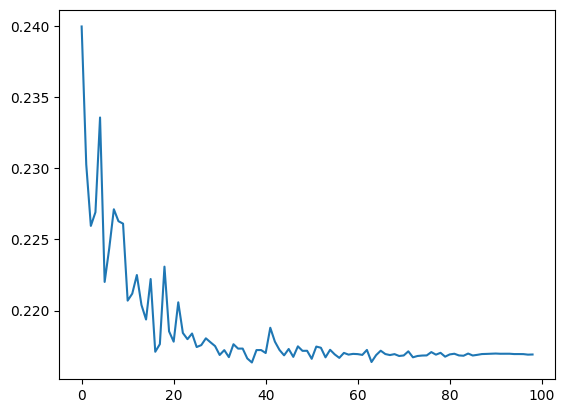

In [10]:
plt.plot([x["val_loss_epoch"] for x in model.stats[2:]])
plt.show()

In [ ]:
import itertools

dim_list = [16,32,64]
conv1_kernel_list = [2,3,4]
rnn_layers_list = [1,2,3]
dropout_list = [0, 0.25, 0.5]

all_combinations = list(itertools.product(dim_list, conv1_kernel_list, rnn_layers_list, dropout_list))

all_stats_list = []

for combination in tqdm(all_combinations):
    dim, conv1_kernel, rnn_layers, dropout = combination
    model = optiver.OptiverModel(mode='multi-stock', dim=dim, conv1_kernel=conv1_kernel, rnn_layers=rnn_layers, rnn_dropout = dropout, aux_loss_weight=0)
    trainer = pl.Trainer(accelerator='auto',
                     precision=16,
                     max_epochs=80,
                     enable_progress_bar=True) # multi-stock
    trainer.fit(model, train_dl, val_dl)
    all_stats_list.append({
        "dim":dim,
        "conv1_kernel":conv1_kernel,
        "rnn_layers":rnn_layers,
        "dropout":dropout,
        "stats": model.stats
    })

  0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type           | Params | Mode 
------------------------------------------------------------
0  | stock_emb       | Embedding      | 1.8 K  | train
1  | conv1           | Conv1d         | 688    | train
2  | conv2           | Conv1d         | 272    | train
3  | norm1           | LayerNorm      | 3.6 K  | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model = optiver.OptiverModel(mode='multi-stock', dim=16, conv1_kernel=1, aux_loss_weight=0) # multi-stock